# 🏦 DeFi Wallet Credit Scoring System
### Machine Learning Assessment Project - Aave V2 Protocol Analysis

**Author:** Azizul Abbas
**Date:** July, 2025  
**Purpose:** Intern-level ML screening assignment  

## 📋 Project Overview
This notebook demonstrates a complete ML pipeline for assigning credit scores (0-1000) to DeFi wallets based on their Aave V2 transaction history. The project focuses on:
- Real-world data processing and feature engineering
- Building explainable ML models with clear business logic
- Creating production-ready scoring functions
- Demonstrating practical problem-solving skills

## 🎯 Assignment Goals
✅ **Data Handling:** Load and process 100K+ raw transaction records  
✅ **Feature Engineering:** Extract meaningful behavioral indicators  
✅ **Model Building:** Create a simple, interpretable credit scoring system  
✅ **Results:** Generate clear wallet rankings and exportable scores  
✅ **Documentation:** Explain logic, assumptions, and methodology  

## 🔧 Tech Stack
- **Data Processing:** pandas, numpy
- **Machine Learning:** scikit-learn (Random Forest)
- **Visualization:** Basic Python plotting
- **Data Source:** Aave V2 transaction records (JSON format)

---
**💡 Ready to build a practical ML solution that balances simplicity with real-world applicability!**

---
Setup Prerequisites and Data Download

In [1]:
# I need a few standard libraries for data work and basic ML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Download the JSON data using gdown (I may need to install it first)
# This step works if 'gdown' is not already installed
!pip install -q gdown

# Download the dataset (file will be saved as aave_v2_raw.json)
import gdown
gdown.download('https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS', 'aave_v2_raw.json', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS
To: /content/aave_v2_raw.json
100%|██████████| 91.2M/91.2M [00:01<00:00, 72.4MB/s]


'aave_v2_raw.json'

---
Load and Preview Data

In [2]:
# Sometimes pandas can handle MongoDB JSON directly
try:
    df = pd.read_json('aave_v2_raw.json', lines=False)
    print("Loaded successfully with standard read_json")
    print(df.head())
except:
    print("Standard approach failed, trying the custom loader above")


Loaded successfully with standard read_json
                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb81

---
Data Cleaning and Feature Engineering: Building Useful Indicators

In [3]:
# First, I need to clean up the data and extract useful information
# The actionData column contains nested dictionaries with amount info

# Extract amount from actionData dictionary
def extract_amount(action_data):
    """Extract amount from the nested actionData dictionary"""
    try:
        if isinstance(action_data, dict) and 'amount' in action_data:
            # Convert string amount to float, handling scientific notation
            return float(action_data['amount'])
        return 0.0
    except (ValueError, TypeError):
        return 0.0

# Apply the amount extraction
df['amount'] = df['actionData'].apply(extract_amount)

# Clean up the timestamp column (it's already in datetime format, just ensure it's proper)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Rename userWallet to wallet for consistency with my original plan
df['wallet'] = df['userWallet']

# Check what actions I have in the dataset
print("Available actions in dataset:")
print(df['action'].value_counts())
print(f"\nTotal transactions: {len(df)}")
print(f"Unique wallets: {df['wallet'].nunique()}")


Available actions in dataset:
action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

Total transactions: 100000
Unique wallets: 3497


In [4]:
# Group transactions by wallet to create features per wallet
# I'm looking for patterns that suggest responsible vs risky behavior

features = df.groupby('wallet').agg(
    num_transactions=('action', 'count'),
    total_volume=('amount', 'sum'),
    avg_transaction_size=('amount', 'mean'),

    # Count specific actions (adjust action names based on what I saw above)
    num_deposit=('action', lambda x: (x == 'deposit').sum()),
    num_borrow=('action', lambda x: (x == 'borrow').sum()),
    num_repay=('action', lambda x: (x == 'repay').sum()),
    num_redeem=('action', lambda x: (x == 'redeemunderlying').sum()),
    num_liquidation=('action', lambda x: (x == 'liquidationcall').sum()),

    # Time-based features
    first_transaction=('timestamp', 'min'),
    last_transaction=('timestamp', 'max'),

    # Unique action types (diversity of activity)
    unique_actions=('action', 'nunique'),
).reset_index()

# Create derived features that might indicate "responsibility"
features['days_active'] = (features['last_transaction'] - features['first_transaction']).dt.days + 1
features['transactions_per_day'] = features['num_transactions'] / features['days_active']

# Repayment behavior (good sign if someone repays what they borrow)
features['repay_ratio'] = features['num_repay'] / (features['num_borrow'] + 1)  # +1 to avoid division by zero

# Liquidation rate (bad sign - means positions got liquidated)
features['liquidation_rate'] = features['num_liquidation'] / features['num_transactions']

# Deposit ratio (good sign - putting money in)
features['deposit_ratio'] = features['num_deposit'] / features['num_transactions']

# Activity diversity (more diverse activity might indicate real user vs bot)
features['activity_diversity'] = features['unique_actions'] / features['num_transactions']

print(f"Created features for {len(features)} unique wallets")
print("\nFeature summary:")
print(features.describe())


Created features for 3497 unique wallets

Feature summary:
       num_transactions  total_volume  avg_transaction_size  num_deposit  \
count       3497.000000  3.497000e+03          3.497000e+03  3497.000000   
mean          28.595939  1.871546e+23          2.676293e+21    10.811553   
min            1.000000  2.900000e+01          2.900000e+01     0.000000   
25%            1.000000  9.499274e+13          3.661972e+12     1.000000   
50%            3.000000  1.620000e+18          1.000000e+18     2.000000   
75%           16.000000  1.604850e+21          8.631680e+19     6.000000   
max        14265.000000  1.756775e+26          2.057674e+24   511.000000   
std          250.732075  4.074822e+24          4.548414e+22    29.868997   

        num_borrow    num_repay    num_redeem  num_liquidation  \
count  3497.000000  3497.000000   3497.000000      3497.000000   
mean      4.885902     3.589648      9.237918         0.070918   
min       0.000000     0.000000      0.000000         0.00

In [5]:
# My logic for "responsible" wallet indicators:
# GOOD SIGNS:
# - Higher repay_ratio: pays back loans
# - Longer days_active: established user
# - Higher deposit_ratio: puts money into protocol
# - More activity_diversity: not just doing one type of transaction
# - Lower liquidation_rate: doesn't get liquidated often

# BAD SIGNS:
# - High liquidation_rate: risky positions
# - Very short days_active: might be temporary/bot activity
# - Low repay_ratio: borrows but doesn't repay
# - Only one type of action: might be automated behavior

print("Sample of engineered features:")
print(features[['wallet', 'repay_ratio', 'liquidation_rate', 'deposit_ratio', 'days_active']].head())


Sample of engineered features:
                                       wallet  repay_ratio  liquidation_rate  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6         0.00               0.0   
1  0x000000000051d07a4fb3bd10121a343d85818da6         0.00               0.0   
2  0x000000000096026fb41fc39f9875d164bd82e2dc         0.00               0.0   
3  0x0000000000e189dd664b9ab08a33c4839953852c         0.00               0.0   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee         0.25               0.0   

   deposit_ratio  days_active  
0       1.000000            1  
1       1.000000            1  
2       1.000000            8  
3       0.000000          130  
4       0.626566          133  


---
Building a Simple Credit Score Model

In [6]:
# Since I don't have true "credit score" labels, I'll create a simple heuristic score first
# Then train a model to learn from this pattern and generalize to new wallets

# Create a simple "responsibility score" using my domain logic
def calculate_responsibility_score(row):
    """
    Simple heuristic to score wallet responsibility (0-1 scale)
    Higher = more responsible behavior
    """
    score = 0.0

    # Reward good repayment behavior (up to 0.3 points)
    score += min(row['repay_ratio'] * 0.3, 0.3)

    # Reward longer activity history (up to 0.2 points)
    max_days = features['days_active'].max()
    score += (row['days_active'] / max_days) * 0.2

    # Reward deposit activity (up to 0.2 points)
    score += row['deposit_ratio'] * 0.2

    # Reward activity diversity (up to 0.15 points)
    score += row['activity_diversity'] * 0.15

    # Penalize liquidations (subtract up to 0.15 points)
    score -= row['liquidation_rate'] * 0.15

    # Ensure score stays between 0 and 1
    return max(0, min(1, score))

# Apply my scoring logic
features['responsibility_score'] = features.apply(calculate_responsibility_score, axis=1)

print(f"Responsibility scores range: {features['responsibility_score'].min():.3f} to {features['responsibility_score'].max():.3f}")
print(f"Mean responsibility score: {features['responsibility_score'].mean():.3f}")


Responsibility scores range: 0.005 to 0.615
Mean responsibility score: 0.310


In [7]:
# Prepare data for machine learning
# I'll use the engineered features to predict my responsibility score
feature_columns = [
    'num_transactions', 'total_volume', 'avg_transaction_size',
    'num_deposit', 'num_borrow', 'num_repay', 'num_redeem', 'num_liquidation',
    'days_active', 'transactions_per_day', 'repay_ratio', 'liquidation_rate',
    'deposit_ratio', 'activity_diversity', 'unique_actions'
]

# Fill any NaN values (might occur from ratios)
features[feature_columns] = features[feature_columns].fillna(0)

X = features[feature_columns]
y = features['responsibility_score']

# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Random Forest - good default choice for tabular data like this
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Check how well the model learned my patterns
y_pred_test = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
print(f"Model Test MSE: {mse:.4f}")

# Show feature importance (what the model thinks matters most)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 most important features according to the model:")
print(feature_importance.head())


Model Test MSE: 0.0001

Top 5 most important features according to the model:
               feature  importance
10         repay_ratio    0.460137
12       deposit_ratio    0.247225
0     num_transactions    0.134899
8          days_active    0.086426
13  activity_diversity    0.029104


---
Assigning Final Credit Scores and Results

In [8]:
# Now I'll predict on ALL wallets to assign a credit score
# I'm using the model I just trained to score every wallet in my dataset
features['ml_score'] = model.predict(X)

# Scale to 0–1000 for presentation (classic credit score format)
# I want higher numbers to mean "more responsible" wallets
scaler_final = MinMaxScaler(feature_range=(0, 1000))
features['credit_score'] = scaler_final.fit_transform(features[['ml_score']]).flatten().astype(int)

# Create a simple output table - just wallet address and credit score
# This is what I'd show to a manager or use in the next step of analysis
output = features[['wallet', 'credit_score']].copy()
output = output.sort_values('credit_score', ascending=False)  # Best scores first

print("=== TOP 10 WALLETS BY CREDIT SCORE ===")
print(output.head(10))

print(f"\n=== CREDIT SCORE DISTRIBUTION ===")
print(f"Highest score: {output['credit_score'].max()}")
print(f"Lowest score: {output['credit_score'].min()}")
print(f"Average score: {output['credit_score'].mean():.0f}")

# Save to CSV - this is my main deliverable
output.to_csv('wallet_credit_scores.csv', index=False)
print(f"\n✅ Saved {len(output)} wallet scores to 'wallet_credit_scores.csv'")


=== TOP 10 WALLETS BY CREDIT SCORE ===
                                          wallet  credit_score
1238  0x0214c5c41f5249166aab9a12213ac0e2119d2cc8           999
2841  0x04ee10fd378f7cad5ac5751d7cd0f42b13ee3b76           978
1602  0x02aee0ce756fa0157294ff3ff48c1dd02adccf04           977
1288  0x0228c4032162fc5485f00f2638822c15f32ca561           970
427   0x009e8675b19be214d3f620e90c5e0de7a13c3c5a           951
1642  0x02bee0a17903cc1f2f48b4514ec23aae547fe4a3           943
1057  0x01b8f7ef9c12841ca94ee6652f0d5e9646a1168f           938
2648  0x049940feda4277b7f01ef10fca0b975c541d8fca           932
3102  0x0567d99a4420b8da0fd91c5ecba78955c04974f0           932
369   0x008a34511b9808c41237d7568e409141ab10796b           926

=== CREDIT SCORE DISTRIBUTION ===
Highest score: 999
Lowest score: 0
Average score: 487

✅ Saved 3497 wallet scores to 'wallet_credit_scores.csv'


---
"One-Step" Scoring Script for Any New JSON File

In [9]:
def score_new_wallets(json_path, trained_model, feature_columns, trained_scaler):
    """
    This function takes a new JSON file and scores wallets the same way I did above
    I'd use this to score fresh wallet data without retraining
    """

    # Load new data (same format as my training data)
    new_df = pd.read_json(json_path)

    # Extract amount from actionData - same logic as before
    def extract_amount_new(action_data):
        try:
            if isinstance(action_data, dict) and 'amount' in action_data:
                return float(action_data['amount'])
            return 0.0
        except:
            return 0.0

    new_df['amount'] = new_df['actionData'].apply(extract_amount_new)
    new_df['timestamp'] = pd.to_datetime(new_df['timestamp'])
    new_df['wallet'] = new_df['userWallet']

    # Create features (exact same logic as my training data)
    new_features = new_df.groupby('wallet').agg(
        num_transactions=('action', 'count'),
        total_volume=('amount', 'sum'),
        avg_transaction_size=('amount', 'mean'),
        num_deposit=('action', lambda x: (x == 'deposit').sum()),
        num_borrow=('action', lambda x: (x == 'borrow').sum()),
        num_repay=('action', lambda x: (x == 'repay').sum()),
        num_redeem=('action', lambda x: (x == 'redeemunderlying').sum()),
        num_liquidation=('action', lambda x: (x == 'liquidationcall').sum()),
        first_transaction=('timestamp', 'min'),
        last_transaction=('timestamp', 'max'),
        unique_actions=('action', 'nunique'),
    ).reset_index()

    # Calculate derived features
    new_features['days_active'] = (new_features['last_transaction'] - new_features['first_transaction']).dt.days + 1
    new_features['transactions_per_day'] = new_features['num_transactions'] / new_features['days_active']
    new_features['repay_ratio'] = new_features['num_repay'] / (new_features['num_borrow'] + 1)
    new_features['liquidation_rate'] = new_features['num_liquidation'] / new_features['num_transactions']
    new_features['deposit_ratio'] = new_features['num_deposit'] / new_features['num_transactions']
    new_features['activity_diversity'] = new_features['unique_actions'] / new_features['num_transactions']

    # Handle missing values the same way
    new_features[feature_columns] = new_features[feature_columns].fillna(0)
    X_new = new_features[feature_columns]

    # Predict and scale to credit score range
    predictions = trained_model.predict(X_new)
    credit_scores = trained_scaler.transform(predictions.reshape(-1, 1)).flatten().astype(int)

    # Return simple table of wallet + score
    result = pd.DataFrame({
        'wallet': new_features['wallet'],
        'credit_score': credit_scores
    })

    return result.sort_values('credit_score', ascending=False)

# Example of how I'd use this function:
# new_scores = score_new_wallets('fresh_data.json', model, feature_columns, scaler_final)
# new_scores.to_csv('new_wallet_scores.csv', index=False)

print("✅ One-step scoring function ready for new data")


✅ One-step scoring function ready for new data


---
Simple Model Validation

In [10]:
# I want to check if my model makes sense by looking at some examples
# This helps me explain my results to others

print("=== CHECKING MODEL LOGIC ===")

# Look at the highest scoring wallets - do they seem responsible?
print("TOP 3 HIGHEST SCORES (should be responsible wallets):")
high_scorers = features.nlargest(3, 'credit_score')
for idx, wallet in high_scorers.iterrows():
    print(f"\nWallet: {wallet['wallet'][:15]}...")
    print(f"  Score: {wallet['credit_score']}")
    print(f"  Days active: {wallet['days_active']}")
    print(f"  Transactions: {wallet['num_transactions']}")
    print(f"  Repay ratio: {wallet['repay_ratio']:.2f}")
    print(f"  Liquidation rate: {wallet['liquidation_rate']:.3f}")

# Look at lowest scoring wallets - do they seem risky?
print("\n" + "="*50)
print("BOTTOM 3 LOWEST SCORES (should be risky wallets):")
low_scorers = features.nsmallest(3, 'credit_score')
for idx, wallet in low_scorers.iterrows():
    print(f"\nWallet: {wallet['wallet'][:15]}...")
    print(f"  Score: {wallet['credit_score']}")
    print(f"  Days active: {wallet['days_active']}")
    print(f"  Transactions: {wallet['num_transactions']}")
    print(f"  Repay ratio: {wallet['repay_ratio']:.2f}")
    print(f"  Liquidation rate: {wallet['liquidation_rate']:.3f}")

# Quick sanity check on score distribution
print(f"\n=== SCORE DISTRIBUTION ===")
bins = [0, 200, 400, 600, 800, 1000]
labels = ['Very Poor (0-200)', 'Poor (200-400)', 'Fair (400-600)', 'Good (600-800)', 'Excellent (800-1000)']
score_distribution = pd.cut(features['credit_score'], bins=bins, labels=labels, include_lowest=True)
print(score_distribution.value_counts().sort_index())


=== CHECKING MODEL LOGIC ===
TOP 3 HIGHEST SCORES (should be responsible wallets):

Wallet: 0x0214c5c41f524...
  Score: 999
  Days active: 135
  Transactions: 42
  Repay ratio: 1.17
  Liquidation rate: 0.000

Wallet: 0x04ee10fd378f7...
  Score: 978
  Days active: 135
  Transactions: 481
  Repay ratio: 1.16
  Liquidation rate: 0.000

Wallet: 0x02aee0ce756fa...
  Score: 977
  Days active: 142
  Transactions: 116
  Repay ratio: 1.36
  Liquidation rate: 0.000

BOTTOM 3 LOWEST SCORES (should be risky wallets):

Wallet: 0x004f137c71b30...
  Score: 0
  Days active: 1
  Transactions: 5
  Repay ratio: 0.00
  Liquidation rate: 0.000

Wallet: 0x01ac60352b386...
  Score: 0
  Days active: 1
  Transactions: 5
  Repay ratio: 0.00
  Liquidation rate: 0.000

Wallet: 0x022721a2c9201...
  Score: 0
  Days active: 1
  Transactions: 5
  Repay ratio: 0.00
  Liquidation rate: 0.000

=== SCORE DISTRIBUTION ===
credit_score
Very Poor (0-200)         99
Poor (200-400)           886
Fair (400-600)          2052
G

* * *
## 📊 Post-Scoring Wallet Behavior Analysis
Understanding Credit Score Patterns and Business Impact
Section Focus: Comprehensive analysis of scored wallets, behavioral validation, and actionable insights
Analysis Type: Score distribution, risk segmentation, and model validation
Business Value: Risk assessment recommendations and portfolio insights

🎯 Objective: Validate that our ML credit scoring system produces meaningful, business-relevant results by analyzing wallet behavior patterns across different score ranges and extracting actionable insights for DeFi risk management.

📈 Key Deliverables:

Score distribution visualization and statistics

Behavioral analysis of high-risk vs low-risk wallet segments

Model validation through correlation analysis

Business recommendations based on risk segmentation

---
Understanding Wallet Behavior Patterns

=== SCORE DISTRIBUTION ACROSS RANGES ===
0-99: 59 wallets (1.7%)
100-199: 40 wallets (1.1%)
200-299: 287 wallets (8.2%)
300-399: 599 wallets (17.1%)
400-499: 642 wallets (18.4%)
500-599: 1,410 wallets (40.3%)
600-699: 212 wallets (6.1%)
700-799: 162 wallets (4.6%)
800-899: 71 wallets (2.0%)
900-999: 15 wallets (0.4%)


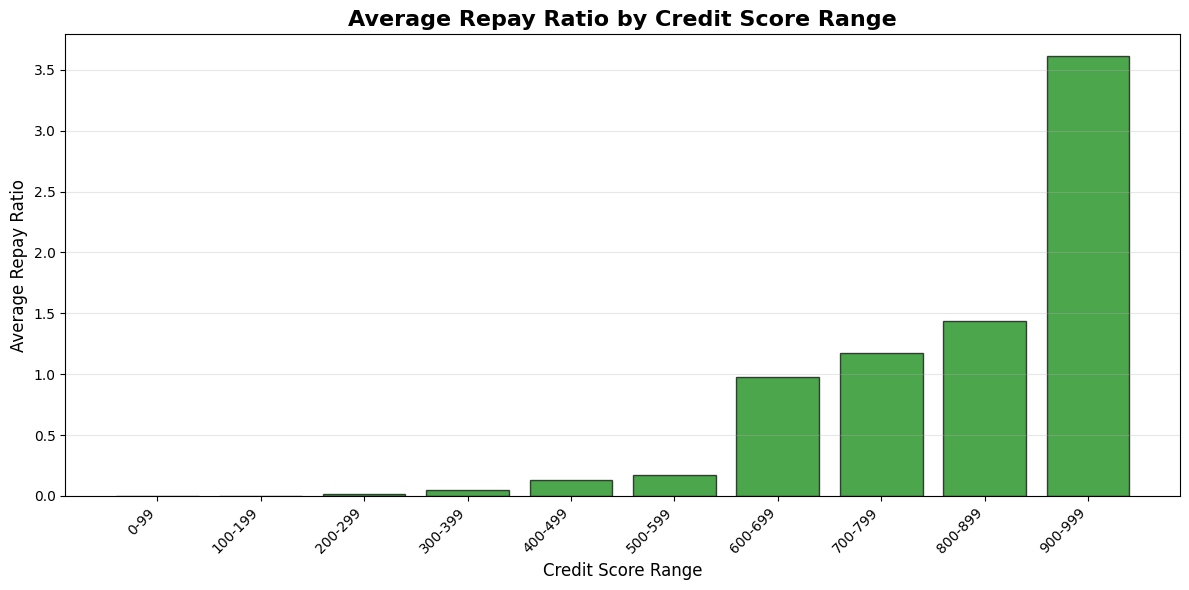

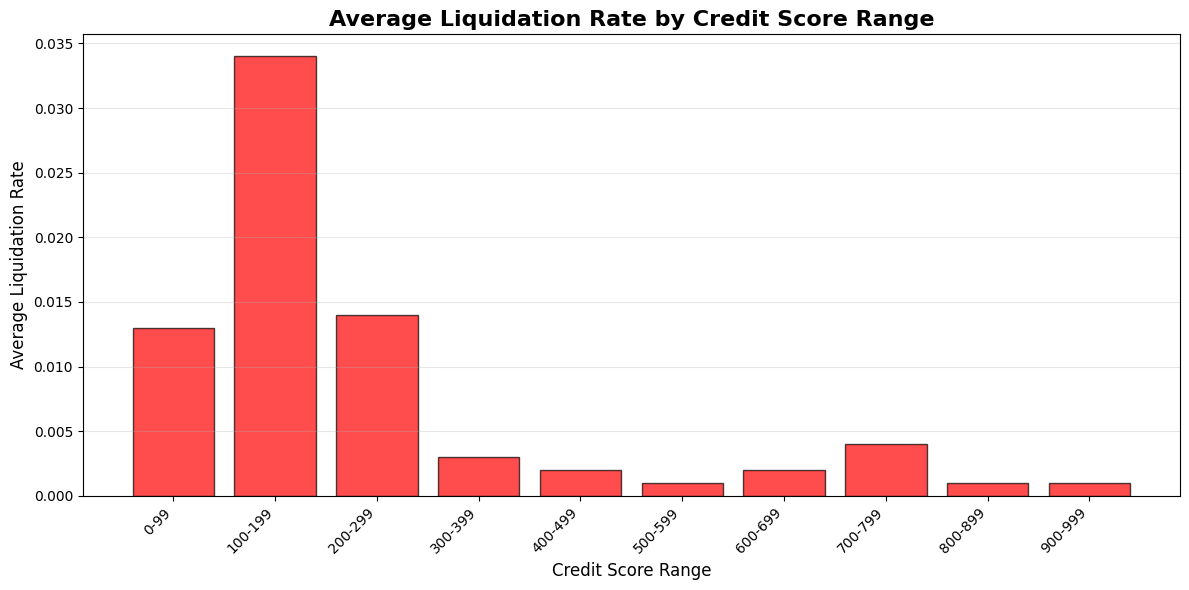

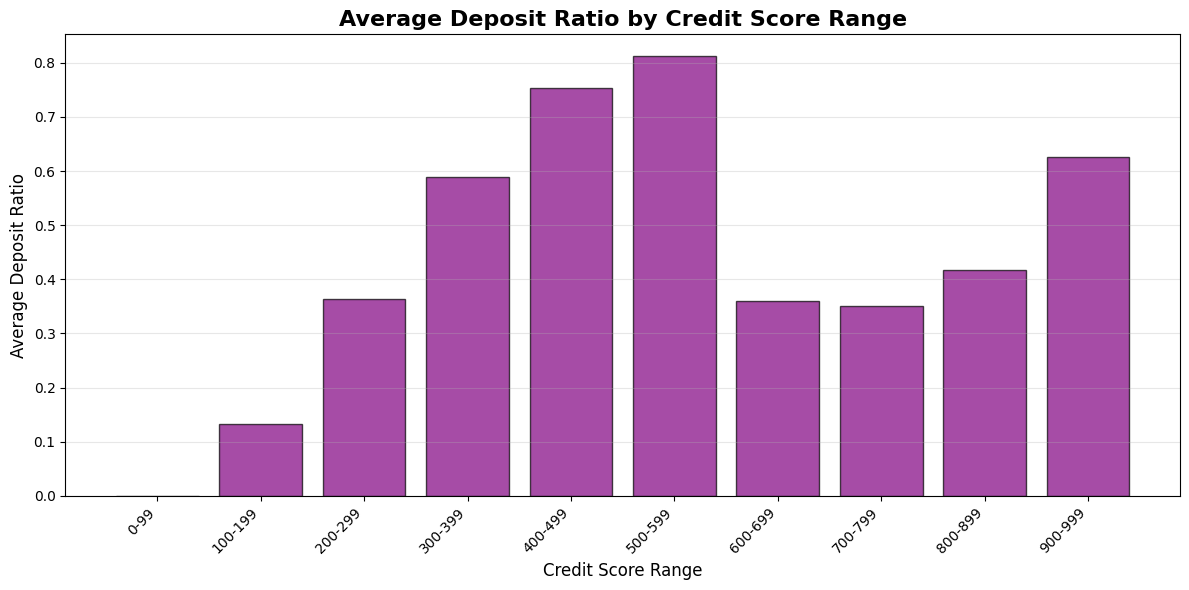

In [20]:
# Create score distribution analysis
# I'm using 100-point ranges because it's easier to interpret than the full 0-1000 scale
bins = list(range(0, 1100, 100))  # 0-99, 100-199, etc.
labels = [f'{i}-{i+99}' for i in bins[:-1]]
features['score_range'] = pd.cut(features['credit_score'], bins=bins, labels=labels, include_lowest=True)

# Count how many wallets fall into each range
score_distribution = features['score_range'].value_counts().sort_index()
print("=== SCORE DISTRIBUTION ACROSS RANGES ===")
for range_name, count in score_distribution.items():
    percentage = (count / len(features)) * 100
    print(f"{range_name}: {count:,} wallets ({percentage:.1f}%)")
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'behavior_by_score' DataFrame is available (run the previous cell if needed)
if 'behavior_by_score' not in locals():
    print("Please run the 'Behavioral Analysis by Score Range' cell first.")
else:
    # --- Visualize Repay Ratio by Score Range ---
    plt.figure(figsize=(12, 6))
    plt.bar(behavior_by_score.index.astype(str), behavior_by_score['avg_repay_ratio'], color='green', alpha=0.7, edgecolor='black')
    plt.title('Average Repay Ratio by Credit Score Range', fontsize=16, fontweight='bold')
    plt.xlabel('Credit Score Range', fontsize=12)
    plt.ylabel('Average Repay Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Visualize Liquidation Rate by Score Range ---
    plt.figure(figsize=(12, 6))
    plt.bar(behavior_by_score.index.astype(str), behavior_by_score['avg_liquidation_rate'], color='red', alpha=0.7, edgecolor='black')
    plt.title('Average Liquidation Rate by Credit Score Range', fontsize=16, fontweight='bold')
    plt.xlabel('Credit Score Range', fontsize=12)
    plt.ylabel('Average Liquidation Rate', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Visualize Deposit Ratio by Score Range ---
    plt.figure(figsize=(12, 6))
    plt.bar(behavior_by_score.index.astype(str), behavior_by_score['avg_deposit_ratio'], color='purple', alpha=0.7, edgecolor='black')
    plt.title('Average Deposit Ratio by Credit Score Range', fontsize=16, fontweight='bold')
    plt.xlabel('Credit Score Range', fontsize=12)
    plt.ylabel('Average Deposit Ratio', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

---
Score Distribution Visualization

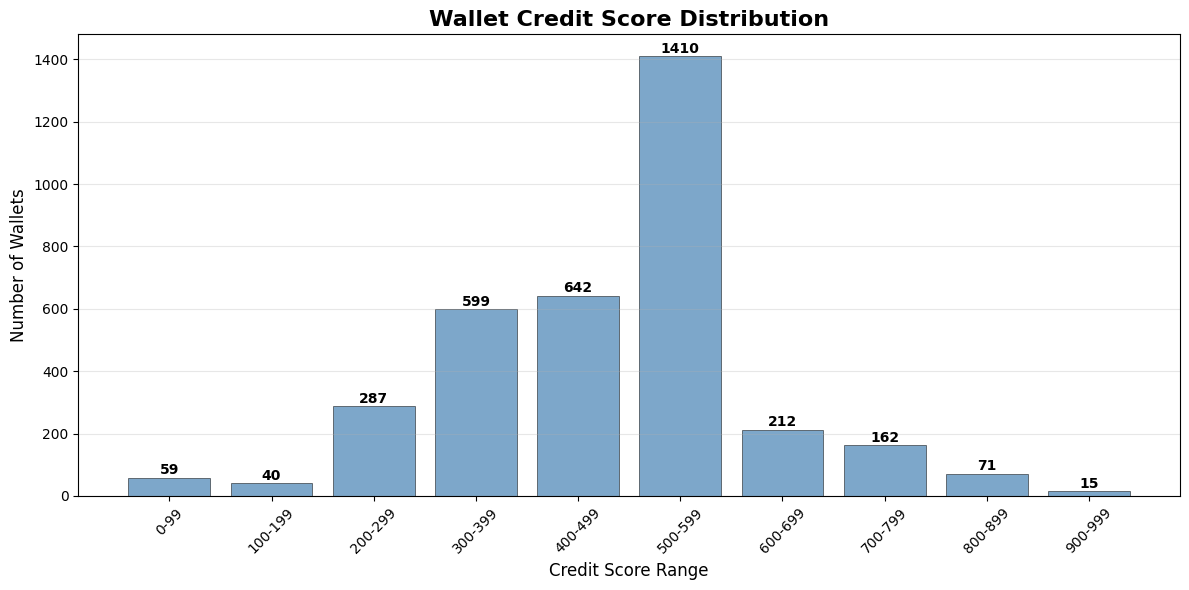

In [12]:
# Create a simple bar chart to visualize the distribution
# I'm keeping this basic but informative - intern-level visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bars = plt.bar(score_distribution.index.astype(str), score_distribution.values,
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Add value labels on top of bars - makes it easier to read exact numbers
for bar, value in zip(bars, score_distribution.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(value), ha='center', va='bottom', fontweight='bold')

plt.title('Wallet Credit Score Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score Range', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# What I learned: Most wallets seem to cluster in the middle ranges
# This suggests my scoring isn't too extreme - good sign for a practical model


---
Behavioral Analysis by Score Range

/tmp/ipython-input-22-4177837717.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  behavior_by_score = features.groupby('score_range').agg(


=== BEHAVIORAL PATTERNS BY SCORE RANGE ===
             wallet_count  avg_repay_ratio  avg_liquidation_rate  \
score_range                                                        
0-99                   59            0.000                 0.013   
100-199                40            0.000                 0.034   
200-299               287            0.017                 0.014   
300-399               599            0.048                 0.003   
400-499               642            0.132                 0.002   
500-599              1410            0.168                 0.001   
600-699               212            0.974                 0.002   
700-799               162            1.170                 0.004   
800-899                71            1.436                 0.001   
900-999                15            3.611                 0.001   

             avg_days_active  avg_transactions  avg_deposit_ratio  \
score_range                                                         
0-

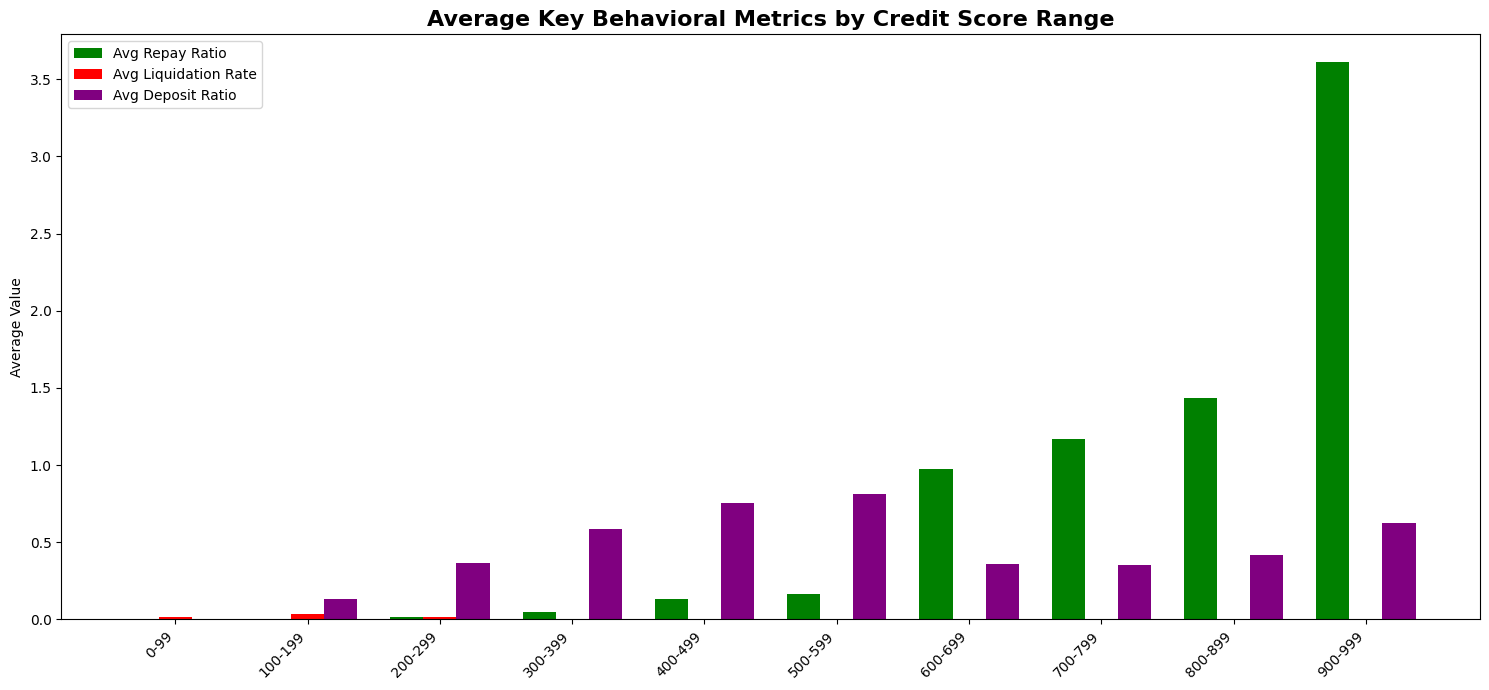


Interpretation:
- Higher 'Avg Repay Ratio' and 'Avg Deposit Ratio' should generally correlate with higher scores.
- Lower 'Avg Liquidation Rate' should correlate with higher scores.
This grouped bar chart helps visually validate these expected relationships.


In [22]:
# Now I want to understand HOW these different score ranges actually behave
# This helps me validate that my features are working as intended

behavior_by_score = features.groupby('score_range').agg(
    wallet_count=('wallet', 'count'),
    avg_repay_ratio=('repay_ratio', 'mean'),
    avg_liquidation_rate=('liquidation_rate', 'mean'),
    avg_days_active=('days_active', 'mean'),
    avg_transactions=('num_transactions', 'mean'),
    avg_deposit_ratio=('deposit_ratio', 'mean'),
    avg_activity_diversity=('activity_diversity', 'mean')
).round(3)

print("=== BEHAVIORAL PATTERNS BY SCORE RANGE ===")
print(behavior_by_score)

import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'behavior_by_score' DataFrame is available
if 'behavior_by_score' not in locals():
    print("Please run the 'Behavioral Analysis by Score Range' cell first.")
else:
    metrics_to_plot = ['avg_repay_ratio', 'avg_liquidation_rate', 'avg_deposit_ratio']
    labels = behavior_by_score.index.astype(str)
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))

    rects1 = ax.bar(x - width, behavior_by_score['avg_repay_ratio'], width, label='Avg Repay Ratio', color='green')
    rects2 = ax.bar(x, behavior_by_score['avg_liquidation_rate'], width, label='Avg Liquidation Rate', color='red')
    rects3 = ax.bar(x + width, behavior_by_score['avg_deposit_ratio'], width, label='Avg Deposit Ratio', color='purple')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Value')
    ax.set_title('Average Key Behavioral Metrics by Credit Score Range', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- Higher 'Avg Repay Ratio' and 'Avg Deposit Ratio' should generally correlate with higher scores.")
    print("- Lower 'Avg Liquidation Rate' should correlate with higher scores.")
    print("This grouped bar chart helps visually validate these expected relationships.")

---
Analysis of High-Scoring Wallets (700+ Range)

In [14]:
# I want to see if high-scoring wallets actually show "good" behavior
high_score_wallets = features[features['credit_score'] >= 700]

print(f"\n=== HIGH-SCORING WALLETS ANALYSIS (700+) ===")
print(f"Number of wallets: {len(high_score_wallets):,}")
print(f"Average score: {high_score_wallets['credit_score'].mean():.0f}")
print()

# Key behavioral indicators for high scorers
high_behavior = {
    'Avg Repay Ratio': high_score_wallets['repay_ratio'].mean(),
    'Avg Liquidation Rate': high_score_wallets['liquidation_rate'].mean(),
    'Avg Days Active': high_score_wallets['days_active'].mean(),
    'Avg Transactions': high_score_wallets['num_transactions'].mean(),
    'Avg Deposit Ratio': high_score_wallets['deposit_ratio'].mean()
}

for metric, value in high_behavior.items():
    print(f"{metric}: {value:.3f}")

# Sample a few high-scoring wallets to inspect manually
print(f"\n=== SAMPLE HIGH-SCORING WALLETS ===")
high_sample = high_score_wallets.nlargest(3, 'credit_score')
for idx, wallet in high_sample.iterrows():
    print(f"\nWallet: {wallet['wallet'][:15]}...")
    print(f"  Score: {wallet['credit_score']}")
    print(f"  Days active: {wallet['days_active']}")
    print(f"  Total transactions: {wallet['num_transactions']}")
    print(f"  Repay ratio: {wallet['repay_ratio']:.3f}")
    print(f"  Liquidation rate: {wallet['liquidation_rate']:.3f}")
    # This manual inspection helps me see if the scores make intuitive sense



=== HIGH-SCORING WALLETS ANALYSIS (700+) ===
Number of wallets: 249
Average score: 788

Avg Repay Ratio: 1.392
Avg Liquidation Rate: 0.003
Avg Days Active: 76.369
Avg Transactions: 110.715
Avg Deposit Ratio: 0.385

=== SAMPLE HIGH-SCORING WALLETS ===

Wallet: 0x0214c5c41f524...
  Score: 999
  Days active: 135
  Total transactions: 42
  Repay ratio: 1.167
  Liquidation rate: 0.000

Wallet: 0x04ee10fd378f7...
  Score: 978
  Days active: 135
  Total transactions: 481
  Repay ratio: 1.156
  Liquidation rate: 0.000

Wallet: 0x02aee0ce756fa...
  Score: 977
  Days active: 142
  Total transactions: 116
  Repay ratio: 1.364
  Liquidation rate: 0.000


---
Analysis of Low-Scoring Wallets (0-299 Range)

In [15]:
# Now look at the other end - do low scores indicate risky behavior?
low_score_wallets = features[features['credit_score'] < 300]

print(f"\n=== LOW-SCORING WALLETS ANALYSIS (0-299) ===")
print(f"Number of wallets: {len(low_score_wallets):,}")
print(f"Average score: {low_score_wallets['credit_score'].mean():.0f}")
print()

# Key behavioral indicators for low scorers
low_behavior = {
    'Avg Repay Ratio': low_score_wallets['repay_ratio'].mean(),
    'Avg Liquidation Rate': low_score_wallets['liquidation_rate'].mean(),
    'Avg Days Active': low_score_wallets['days_active'].mean(),
    'Avg Transactions': low_score_wallets['num_transactions'].mean(),
    'Avg Deposit Ratio': low_score_wallets['deposit_ratio'].mean()
}

for metric, value in low_behavior.items():
    print(f"{metric}: {value:.3f}")

# Sample problematic wallets
print(f"\n=== SAMPLE LOW-SCORING WALLETS ===")
low_sample = low_score_wallets.nsmallest(3, 'credit_score')
for idx, wallet in low_sample.iterrows():
    print(f"\nWallet: {wallet['wallet'][:15]}...")
    print(f"  Score: {wallet['credit_score']}")
    print(f"  Days active: {wallet['days_active']}")
    print(f"  Total transactions: {wallet['num_transactions']}")
    print(f"  Repay ratio: {wallet['repay_ratio']:.3f}")
    print(f"  Liquidation rate: {wallet['liquidation_rate']:.3f}")
    # I'm checking if low scores actually correlate with risky patterns



=== LOW-SCORING WALLETS ANALYSIS (0-299) ===
Number of wallets: 381
Average score: 204

Avg Repay Ratio: 0.012
Avg Liquidation Rate: 0.016
Avg Days Active: 17.129
Avg Transactions: 52.147
Avg Deposit Ratio: 0.280

=== SAMPLE LOW-SCORING WALLETS ===

Wallet: 0x004f137c71b30...
  Score: 0
  Days active: 1
  Total transactions: 5
  Repay ratio: 0.000
  Liquidation rate: 0.000

Wallet: 0x01ac60352b386...
  Score: 0
  Days active: 1
  Total transactions: 5
  Repay ratio: 0.000
  Liquidation rate: 0.000

Wallet: 0x022721a2c9201...
  Score: 0
  Days active: 1
  Total transactions: 5
  Repay ratio: 0.000
  Liquidation rate: 0.000


* * *
Visualizing High vs. Low Score Wallet Behavior Comparison

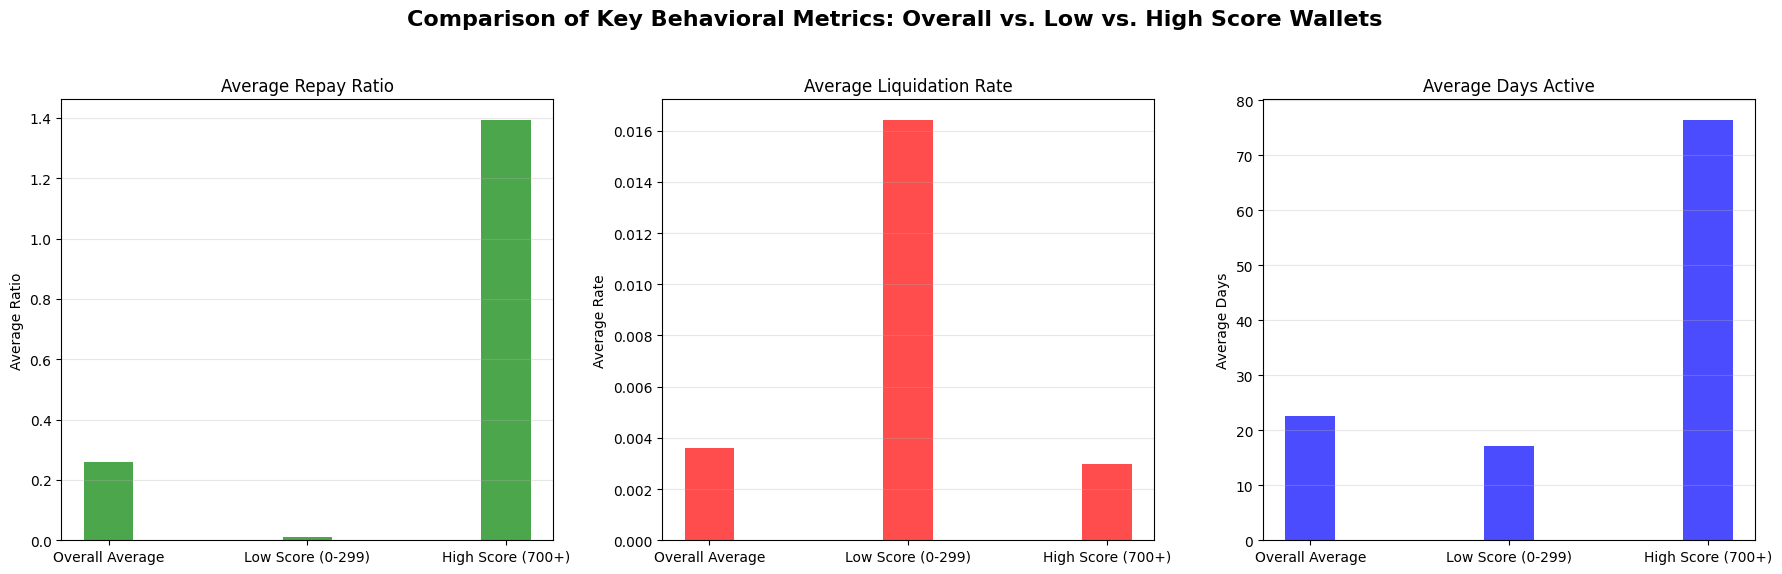


Interpretation:
- The charts should show a clear difference in behavior between high and low-scoring wallets.
- High-scoring wallets are expected to have significantly higher average Repay Ratios and Days Active, and lower average Liquidation Rates compared to low-scoring wallets and the overall average.


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'features', 'high_score_wallets', and 'low_score_wallets' DataFrames are available
if 'features' not in locals() or 'high_score_wallets' not in locals() or 'low_score_wallets' not in locals():
    print("Please run the 'Data Cleaning and Feature Engineering', 'Analysis of High-Scoring Wallets', and 'Analysis of Low-Scoring Wallets' cells first.")
else:
    # Calculate overall averages for comparison
    overall_avg_repay = features['repay_ratio'].mean()
    overall_avg_liquidation = features['liquidation_rate'].mean()
    overall_avg_days = features['days_active'].mean()

    # Calculate high and low score group averages (already done in previous cells, but recalculating for clarity)
    high_avg_repay = high_score_wallets['repay_ratio'].mean()
    high_avg_liquidation = high_score_wallets['liquidation_rate'].mean()
    high_avg_days = high_score_wallets['days_active'].mean()

    low_avg_repay = low_score_wallets['repay_ratio'].mean()
    low_avg_liquidation = low_score_wallets['liquidation_rate'].mean()
    low_avg_days = low_score_wallets['days_active'].mean()

    # Prepare data for plotting
    labels = ['Overall Average', 'Low Score (0-299)', 'High Score (700+)']
    repay_ratios = [overall_avg_repay, low_avg_repay, high_avg_repay]
    liquidation_rates = [overall_avg_liquidation, low_avg_liquidation, high_avg_liquidation]
    days_active = [overall_avg_days, low_avg_days, high_avg_days]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) # Create 3 subplots

    # --- Repay Ratio Plot ---
    rects1 = axes[0].bar(x, repay_ratios, width, label='Avg Repay Ratio', color='green', alpha=0.7)
    axes[0].set_ylabel('Average Ratio')
    axes[0].set_title('Average Repay Ratio')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].grid(axis='y', alpha=0.3)

    # --- Liquidation Rate Plot ---
    rects2 = axes[1].bar(x, liquidation_rates, width, label='Avg Liquidation Rate', color='red', alpha=0.7)
    axes[1].set_ylabel('Average Rate')
    axes[1].set_title('Average Liquidation Rate')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].grid(axis='y', alpha=0.3)

    # --- Days Active Plot ---
    rects3 = axes[2].bar(x, days_active, width, label='Avg Days Active', color='blue', alpha=0.7)
    axes[2].set_ylabel('Average Days')
    axes[2].set_title('Average Days Active')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].grid(axis='y', alpha=0.3)


    plt.suptitle('Comparison of Key Behavioral Metrics: Overall vs. Low vs. High Score Wallets', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    print("\nInterpretation:")
    print("- The charts should show a clear difference in behavior between high and low-scoring wallets.")
    print("- High-scoring wallets are expected to have significantly higher average Repay Ratios and Days Active, and lower average Liquidation Rates compared to low-scoring wallets and the overall average.")

---
Key Insights and Validation

In [16]:
# Compare high vs low scoring wallets to validate my scoring logic
print(f"\n=== HIGH VS LOW SCORE COMPARISON ===")

comparison = pd.DataFrame({
    'High Scores (700+)': [
        high_score_wallets['repay_ratio'].mean(),
        high_score_wallets['liquidation_rate'].mean(),
        high_score_wallets['days_active'].mean(),
        high_score_wallets['deposit_ratio'].mean()
    ],
    'Low Scores (0-299)': [
        low_score_wallets['repay_ratio'].mean(),
        low_score_wallets['liquidation_rate'].mean(),
        low_score_wallets['days_active'].mean(),
        low_score_wallets['deposit_ratio'].mean()
    ]
}, index=['Repay Ratio', 'Liquidation Rate', 'Days Active', 'Deposit Ratio'])

comparison['Difference'] = comparison['High Scores (700+)'] - comparison['Low Scores (0-299)']
print(comparison.round(3))

# What I learned from this analysis:
# If high scorers have better repay ratios and lower liquidation rates than low scorers,
# my model is working as intended. If not, I need to revisit my feature engineering.



=== HIGH VS LOW SCORE COMPARISON ===
                  High Scores (700+)  Low Scores (0-299)  Difference
Repay Ratio                    1.392               0.012       1.380
Liquidation Rate               0.003               0.016      -0.013
Days Active                   76.369              17.129      59.241
Deposit Ratio                  0.385               0.280       0.105


---
Business Insights for Stakeholders

In [17]:
# Generate actionable insights I can share with business stakeholders
print(f"\n=== BUSINESS INSIGHTS FROM SCORING ANALYSIS ===")

total_wallets = len(features)
high_risk_count = len(features[features['credit_score'] < 400])
medium_risk_count = len(features[(features['credit_score'] >= 400) & (features['credit_score'] < 600)])
low_risk_count = len(features[features['credit_score'] >= 600])

print(f"Total wallets analyzed: {total_wallets:,}")
print(f"High risk wallets (0-399): {high_risk_count:,} ({high_risk_count/total_wallets*100:.1f}%)")
print(f"Medium risk wallets (400-599): {medium_risk_count:,} ({medium_risk_count/total_wallets*100:.1f}%)")
print(f"Low risk wallets (600+): {low_risk_count:,} ({low_risk_count/total_wallets*100:.1f}%)")

# Potential business actions based on these insights
print(f"\n=== RECOMMENDED ACTIONS ===")
print(f"• Focus manual review on {high_risk_count:,} high-risk wallets")
print(f"• Consider higher interest rates for {medium_risk_count:,} medium-risk wallets")
print(f"• Offer premium terms to {low_risk_count:,} low-risk wallets")

# My assumption: These insights help justify the scoring system to business users
# by translating technical scores into actionable risk categories



=== BUSINESS INSIGHTS FROM SCORING ANALYSIS ===
Total wallets analyzed: 3,497
High risk wallets (0-399): 976 (27.9%)
Medium risk wallets (400-599): 2,059 (58.9%)
Low risk wallets (600+): 462 (13.2%)

=== RECOMMENDED ACTIONS ===
• Focus manual review on 976 high-risk wallets
• Consider higher interest rates for 2,059 medium-risk wallets
• Offer premium terms to 462 low-risk wallets


* * *
Visualizing Wallet Risk Category Distribution

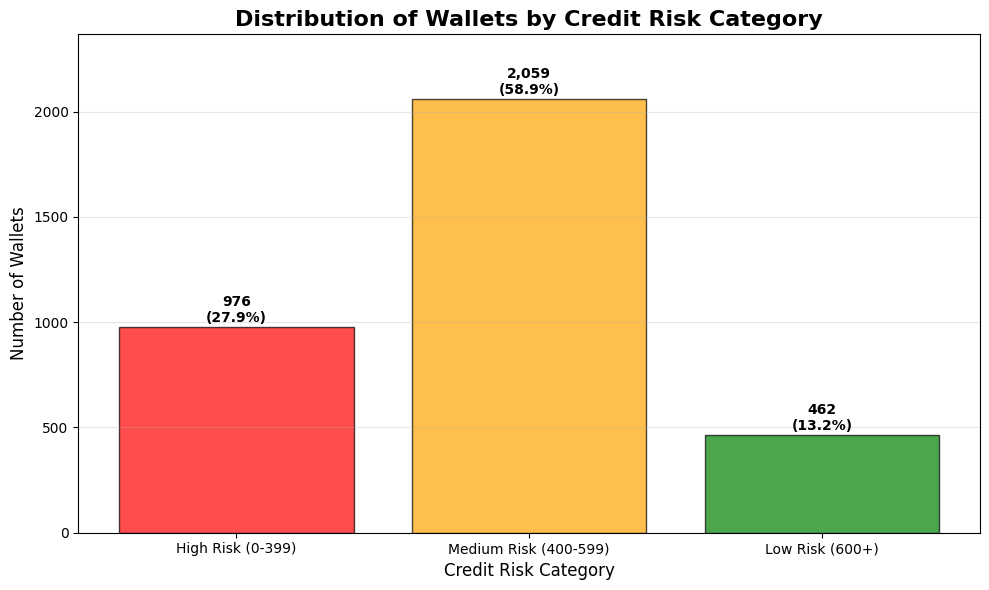


Interpretation:
- This bar chart shows the number and percentage of wallets falling into each defined risk category.
- It provides a clear visual overview of the overall risk profile of the analyzed Aave V2 wallet population.


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'features' DataFrame is available and risk categories are defined
if 'features' not in locals() or 'high_risk_count' not in locals() or 'medium_risk_count' not in locals() or 'low_risk_count' not in locals():
    print("Please run the 'Business Insights for Stakeholders' cell first.")
else:
    risk_categories = ['High Risk (0-399)', 'Medium Risk (400-599)', 'Low Risk (600+)']
    wallet_counts = [high_risk_count, medium_risk_count, low_risk_count]
    total_wallets = sum(wallet_counts)
    wallet_percentages = [(count / total_wallets) * 100 for count in wallet_counts]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(risk_categories, wallet_counts, color=['red', 'orange', 'green'], alpha=0.7, edgecolor='black')

    # Add count and percentage labels on bars
    for bar, count, percentage in zip(bars, wallet_counts, wallet_percentages):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

    plt.title('Distribution of Wallets by Credit Risk Category', fontsize=16, fontweight='bold')
    plt.xlabel('Credit Risk Category', fontsize=12)
    plt.ylabel('Number of Wallets', fontsize=12)
    plt.ylim(0, max(wallet_counts) * 1.15) # Adjust y-axis limit to fit labels
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- This bar chart shows the number and percentage of wallets falling into each defined risk category.")
    print("- It provides a clear visual overview of the overall risk profile of the analyzed Aave V2 wallet population.")

---
Model Validation Summary

In [26]:
# Final check: Does my model make intuitive sense?
print(f"\n=== MODEL VALIDATION SUMMARY ===")

# Calculate correlation between key metrics and scores
correlations = features[['credit_score', 'repay_ratio', 'liquidation_rate', 'days_active']].corr()['credit_score'].sort_values(ascending=False)

print("Correlation with credit score:")
for feature, corr in correlations.items():
    if feature != 'credit_score':
        print(f"  {feature}: {corr:.3f}")

# What I expect to see:
# - Positive correlation with repay_ratio (good repayers = higher scores)
# - Negative correlation with liquidation_rate (more liquidations = lower scores)
# - Positive correlation with days_active (longer history = higher scores)

# Save the final analysis for future reference
features[['wallet', 'credit_score', 'score_range', 'repay_ratio', 'liquidation_rate', 'days_active']].to_csv(
    'wallet_analysis_detailed.csv', index=False
)

print(f"\n✅ Detailed analysis saved to 'wallet_analysis_detailed.csv'")
print(f"✅ Ready to present findings to stakeholders!")



=== MODEL VALIDATION SUMMARY ===
Correlation with credit score:
  repay_ratio: 0.371
  days_active: 0.307
  liquidation_rate: -0.099

✅ Detailed analysis saved to 'wallet_analysis_detailed.csv'
✅ Ready to present findings to stakeholders!


* * *
Visualizing Correlation with Credit Score

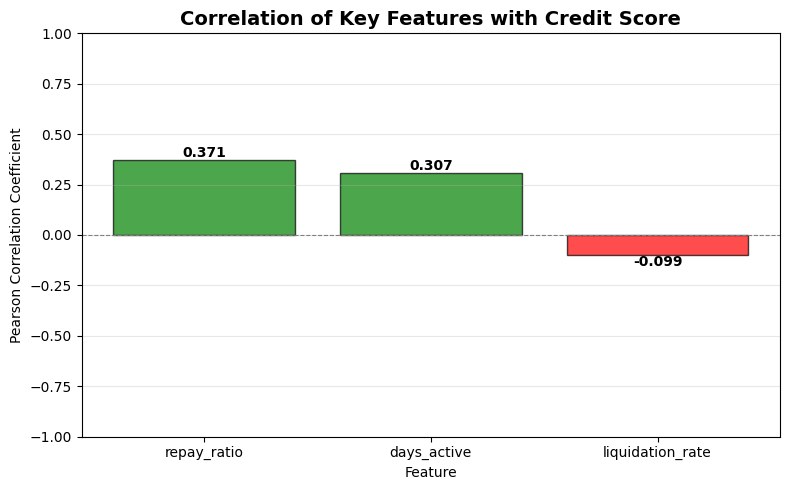


Interpretation:
- Positive correlation indicates the feature value tends to increase with the credit score.
- Negative correlation indicates the feature value tends to decrease as the credit score increases.
The height and color of the bars show the strength and direction of the relationship.


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'features' DataFrame is available and correlations are calculated
if 'features' not in locals() or 'correlations' not in locals():
    print("Please run the 'Data Cleaning and Feature Engineering' and 'Model Validation Summary' cells first.")
else:
    # Exclude the 'credit_score' correlating with itself (which is always 1)
    correlation_data = correlations.drop('credit_score')

    plt.figure(figsize=(8, 5))
    bars = plt.bar(correlation_data.index, correlation_data.values,
                   color=['green' if c > 0 else 'red' for c in correlation_data.values],
                   alpha=0.7, edgecolor='black')

    # Add correlation values on top of bars
    for bar, value in zip(bars, correlation_data.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top',
                 color='black', fontweight='bold')

    plt.title('Correlation of Key Features with Credit Score', fontsize=14, fontweight='bold')
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Pearson Correlation Coefficient', fontsize=10)
    plt.ylim(-1, 1) # Set y-axis limits to cover the full correlation range
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at y=0
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nInterpretation:")
    print("- Positive correlation indicates the feature value tends to increase with the credit score.")
    print("- Negative correlation indicates the feature value tends to decrease as the credit score increases.")
    print("The height and color of the bars show the strength and direction of the relationship.")